In [ ]:
import os
import pandas as pd
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = 'AudioWAV/'
audio_files = os.listdir(path)
#categorize files by emotion
#quantify how many of files per emotion
emotion_map = {
    'SAD': 'sadness',
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happiness',
    'NEU': 'neutral',
    #'SUR': 'surprise'
}
emotion_data = []
for i in range(len(audio_files)):
    emotion_data.append(emotion_map.get(audio_files[i].split("_")[2]))
data = {
    'audio_file': audio_files,
    'emotion': emotion_data
}
df = pd.DataFrame(data)
# df

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

TARGET_SAMPLE_RATE = feature_extractor.sampling_rate
TARGET_DURATION_SECONDS = 3.0 # Keeping the target duration consistent with previous processing

def preprocess_audio_for_wav2vec2(audio_path):
    # Load audio file with librosa
    waveform, sample_rate = librosa.load(audio_path, sr=TARGET_SAMPLE_RATE)

    # Pad/truncate to TARGET_DURATION_SECONDS
    target_num_samples = int(TARGET_DURATION_SECONDS * TARGET_SAMPLE_RATE)
    if len(waveform) < target_num_samples:
        # Pad with zeros
        padding = target_num_samples - len(waveform)
        waveform = np.pad(waveform, (0, padding), mode='constant')
    elif len(waveform) > target_num_samples:
        # Truncate
        waveform = waveform[:target_num_samples]

    return waveform

X_wav2vec = []
y_wav2vec = []

print("Data preprocessing...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    processed_audio = preprocess_audio_for_wav2vec2(path+row['audio_file'])
    X_wav2vec.append(processed_audio)
    y_wav2vec.append(row['emotion'])

X_wav2vec = np.array(X_wav2vec)
y_wav2vec = np.array(y_wav2vec)
print(f"Shape of X_wav2vec: {X_wav2vec.shape}")
print(f"Shape of y_wav2vec: {y_wav2vec.shape}")

/home/j_fu/anaconda3/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Data preprocessing...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7442/7442 [00:01<00:00, 6359.04it/s]


Shape of X_wav2vec: (7442, 48000)
Shape of y_wav2vec: (7442,)


In [ ]:
le_wav2vec = LabelEncoder()
y_wav2vec_encoded = le_wav2vec.fit_transform(y_wav2vec)

In [ ]:
# Load a pre-trained Wav2Vec2 model with a classification head
id2label = {i: label for i, label in enumerate(le_wav2vec.classes_)}
label2id = {label: i for i, label in enumerate(le_wav2vec.classes_)}

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(le_wav2vec.classes_),
    id2label=id2label,
    label2id=label2id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/j_fu/anaconda3/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Split data
X_train_wav2vec, X_test_wav2vec, y_train_wav2vec, y_test_wav2vec = train_test_split(
    X_wav2vec, y_wav2vec_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_wav2vec_encoded,
    shuffle=True
)

print(f"X_train_wav2vec shape: {X_train_wav2vec.shape}")
print(f"y_train_wav2vec shape: {y_train_wav2vec.shape}")
print(f"X_test_wav2vec shape: {X_test_wav2vec.shape}")
print(f"y_test_wav2vec shape: {y_test_wav2vec.shape}")

X_train_wav2vec shape: (5953, 48000)
y_train_wav2vec shape: (5953,)
X_test_wav2vec shape: (1489, 48000)
y_test_wav2vec shape: (1489,)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_wav2vec)
y_train_tensor = torch.LongTensor(y_train_wav2vec)
X_test_tensor = torch.FloatTensor(X_test_wav2vec)
y_test_tensor = torch.LongTensor(y_test_wav2vec)

# Create TensorDatasets and DataLoaders
train_dataset_wav2vec = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_wav2vec = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader_wav2vec = DataLoader(train_dataset_wav2vec, batch_size=batch_size, shuffle=True)
test_loader_wav2vec = DataLoader(test_dataset_wav2vec, batch_size=batch_size, shuffle=False)

In [ ]:
def reset_weights(model):
    if isinstance(model, Wav2Vec2ForSequenceClassification):
        # For Wav2Vec2ForSequenceClassification, only reset the classification head
        if hasattr(model, 'classifier') and hasattr(model.classifier, 'reset_parameters'):
            model.classifier.reset_parameters()
        if hasattr(model, 'projector') and hasattr(model.projector, 'reset_parameters'):
            model.projector.reset_parameters()
    else:
        # For other models, reset all layers
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [ ]:
def run_model(model, train_loader, test_loader, learning_rate=1e-4, weight_decay=1e-3, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    reset_weights(model)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    best_test_acc = 0.0
    best_epoch = 0
    patience = 10 # early stop
    patience_counter = 0
    best_model_state = None

    # pbar = tqdm(total=num_epochs * len(train_loader), desc='Training')

    for epoch in range(num_epochs):
        # print(f'Epoch: {epoch + 1}/{num_epochs}')

        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if isinstance(model, Wav2Vec2ForSequenceClassification):
                outputs = model(input_values=inputs, labels=labels) # HF model internal loss
                loss = outputs.loss
                logits = outputs.logits
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                logits = outputs

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits, 1) # prediction
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # pbar.update(1)

        # Validation
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                if isinstance(model, Wav2Vec2ForSequenceClassification):
                    outputs = model(input_values=inputs) # no labels for inference
                    logits = outputs.logits
                else:
                    outputs = model(inputs)
                    logits = outputs

                _, predicted = torch.max(logits, 1) # prediction
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # Calculate metrics
        avg_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        test_acc = 100 * test_correct / test_total

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        # Early stop
        indicator = ""
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch + 1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            indicator = "*"
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0 or indicator == '*':
            print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
                  f'Loss: {avg_loss:.4f} | '
                  f'Train Acc: {train_acc:.2f}% | '
                  f'Test Acc: {test_acc:.2f}% {indicator}')

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Best test accuracy: {best_test_acc:.2f}% at epoch {best_epoch}")
            model.load_state_dict(best_model_state)
            break

    # Load best model
    if patience_counter < patience and best_model_state is not None:
        print(f"Loading best model from epoch {best_epoch} ({best_test_acc:.2f}%)")
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def graph_model(history, label_encoder):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader_wav2vec: # use test dataloader
          inputs = inputs.to(device)

          if isinstance(model, Wav2Vec2ForSequenceClassification):
              outputs = model(input_values=inputs)
              logits = outputs.logits
          else:
              outputs = model(inputs)
              logits = outputs

          _, predicted = torch.max(logits, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.numpy())

  # Classification report
  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

  # Confusion matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()

  # Plot training history
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.plot(history['train_loss'])
  ax1.set_title('Training Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid(True)

  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['test_acc'], label='Test Accuracy')
  ax2.set_title('Model Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-4, weight_decay=1e-3, num_epochs=20)

Epoch [ 1/20] | Loss: 1.3394 | Train Acc: 47.09% | Test Acc: 51.65% *
Epoch [ 2/20] | Loss: 1.0364 | Train Acc: 61.36% | Test Acc: 64.88% *
Epoch [ 4/20] | Loss: 0.7484 | Train Acc: 72.92% | Test Acc: 69.11% *
Epoch [ 5/20] | Loss: 0.7009 | Train Acc: 74.69% | Test Acc: 69.31% *
Epoch [10/20] | Loss: 0.4167 | Train Acc: 85.03% | Test Acc: 67.76% 
Epoch [15/20] | Loss: 0.2897 | Train Acc: 89.90% | Test Acc: 63.87% 
Early stopping at epoch 15
Best test accuracy: 69.31% at epoch 5



Classification Report:
              precision    recall  f1-score   support

       anger       0.72      0.85      0.78       254
     disgust       0.80      0.39      0.52       254
        fear       0.45      0.81      0.58       254
   happiness       0.73      0.65      0.69       255
     neutral       0.75      0.72      0.74       218
     sadness       0.63      0.41      0.50       254

    accuracy                           0.64      1489
   macro avg       0.68      0.64      0.63      1489
weighted avg       0.68      0.64      0.63      1489



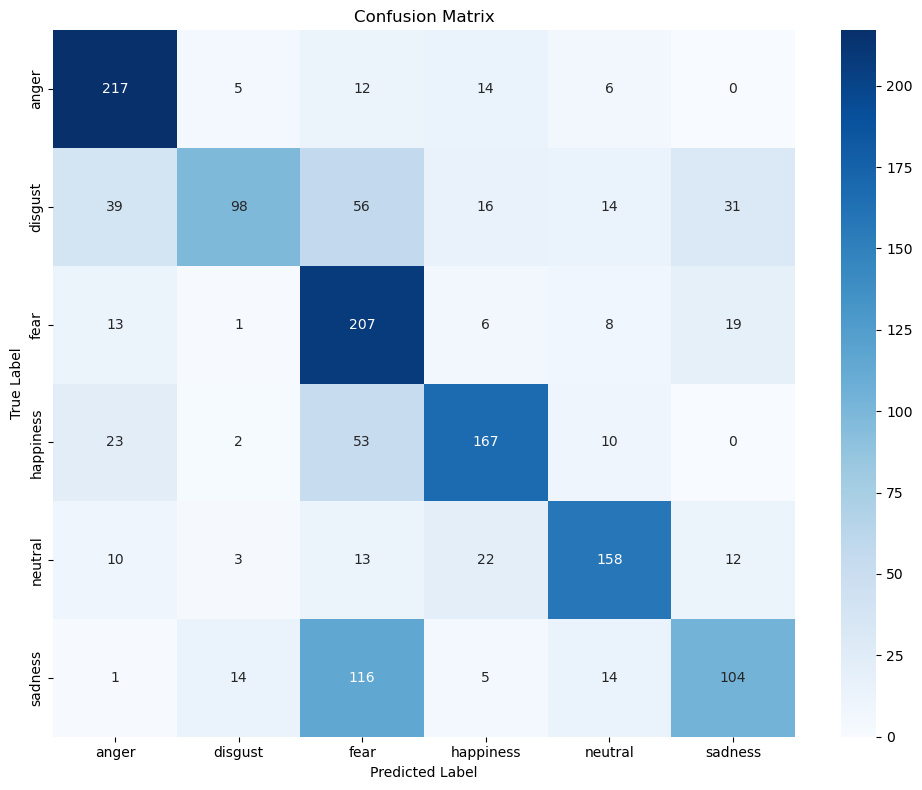

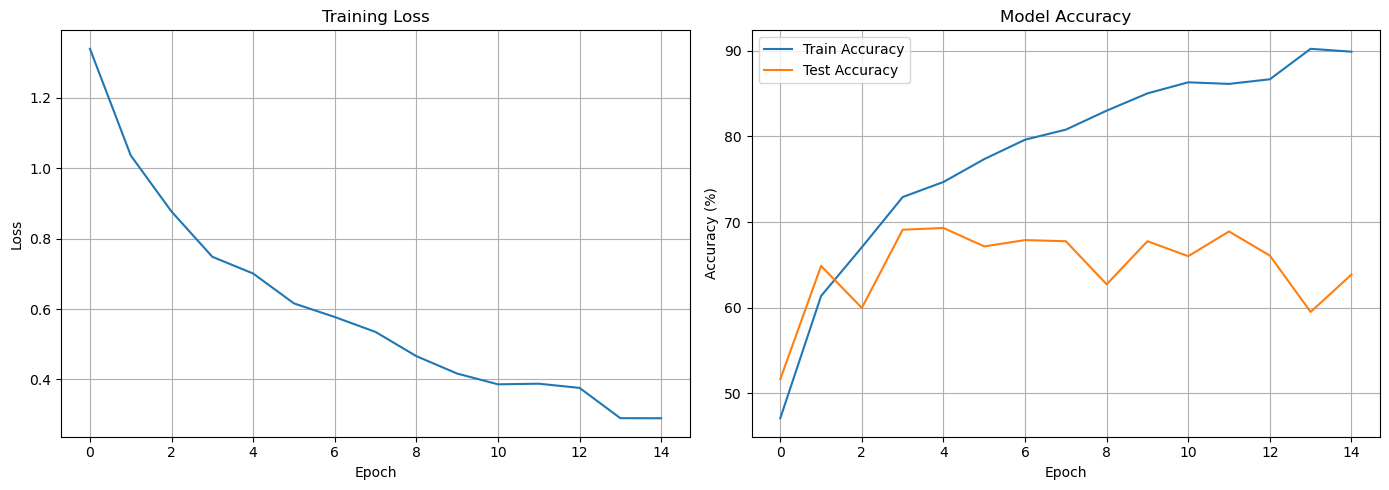

In [ ]:
graph_model(history, le_wav2vec)

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-4, weight_decay=1e-3, num_epochs=20)

Epoch [ 1/20] | Loss: 1.4827 | Train Acc: 38.96% | Test Acc: 50.44% *
Epoch [ 2/20] | Loss: 1.1513 | Train Acc: 56.09% | Test Acc: 66.49% *
Epoch [ 5/20] | Loss: 0.7638 | Train Acc: 72.40% | Test Acc: 63.47% 
Epoch [ 6/20] | Loss: 0.8030 | Train Acc: 71.04% | Test Acc: 69.31% *
Epoch [10/20] | Loss: 0.5655 | Train Acc: 79.66% | Test Acc: 65.21% 
Epoch [15/20] | Loss: 0.3495 | Train Acc: 87.15% | Test Acc: 58.50% 
Early stopping at epoch 16
Best test accuracy: 69.31% at epoch 6



Classification Report:
              precision    recall  f1-score   support

       anger       0.63      0.84      0.72       254
     disgust       0.62      0.51      0.56       254
        fear       0.58      0.58      0.58       254
   happiness       0.66      0.46      0.54       255
     neutral       0.61      0.77      0.68       218
     sadness       0.60      0.56      0.58       254

    accuracy                           0.61      1489
   macro avg       0.62      0.62      0.61      1489
weighted avg       0.62      0.61      0.61      1489



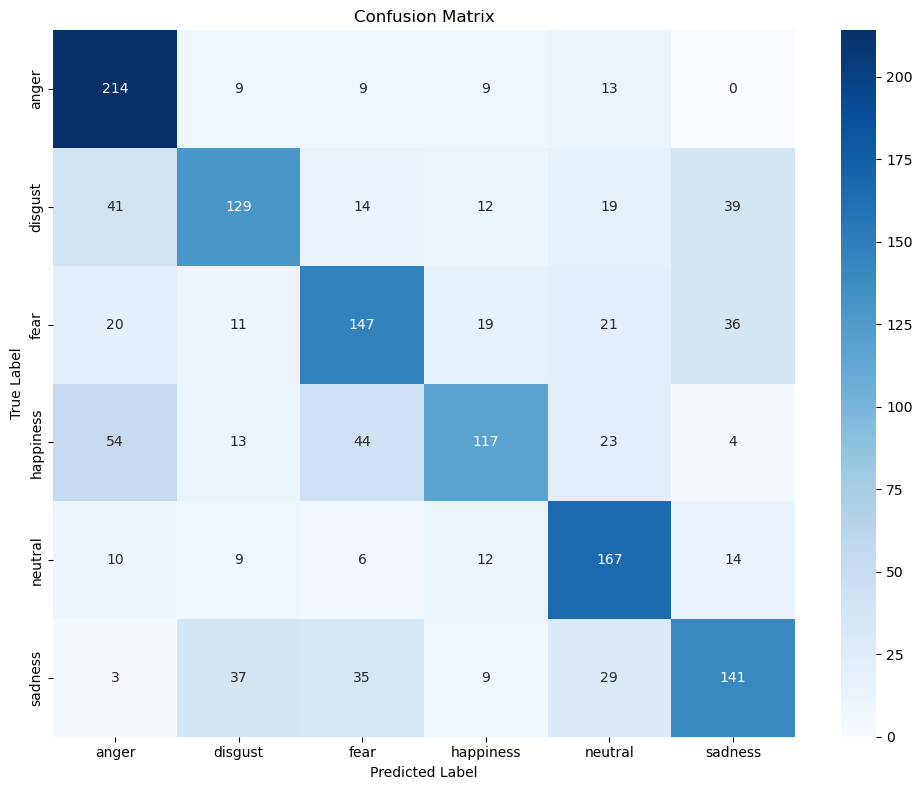

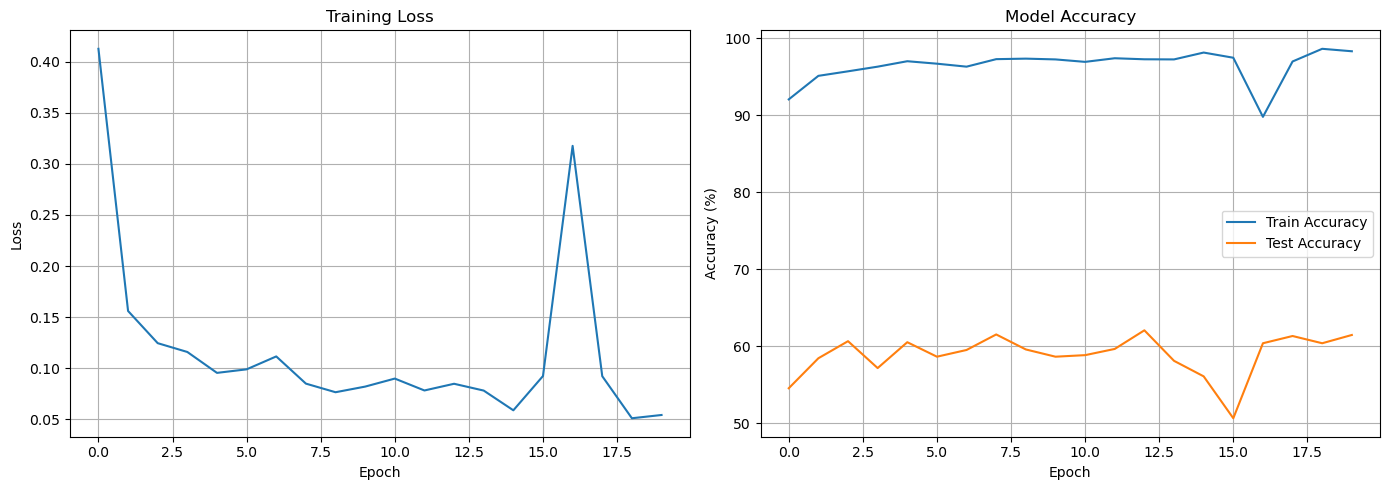

In [ ]:
graph_model(history, le_wav2vec)

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-5, weight_decay=1e-3, num_epochs=20)

Epoch [ 1/20] | Loss: 1.2168 | Train Acc: 92.02% | Test Acc: 58.23% *
Epoch [ 2/20] | Loss: 0.5218 | Train Acc: 99.41% | Test Acc: 61.52% *
Epoch [ 5/20] | Loss: 0.0921 | Train Acc: 99.71% | Test Acc: 60.71% 
Epoch [ 6/20] | Loss: 0.0688 | Train Acc: 99.60% | Test Acc: 61.79% *
Epoch [10/20] | Loss: 0.0271 | Train Acc: 99.78% | Test Acc: 61.38% 
Epoch [13/20] | Loss: 0.0190 | Train Acc: 99.83% | Test Acc: 62.06% *
Epoch [15/20] | Loss: 0.0181 | Train Acc: 99.71% | Test Acc: 61.38% 
Epoch [16/20] | Loss: 0.0152 | Train Acc: 99.78% | Test Acc: 62.26% *
Epoch [19/20] | Loss: 0.0119 | Train Acc: 99.83% | Test Acc: 62.59% *
Epoch [20/20] | Loss: 0.0132 | Train Acc: 99.68% | Test Acc: 62.53% 
Loading best model from epoch 19 (62.59%)



Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.81      0.75       254
     disgust       0.59      0.54      0.57       254
        fear       0.58      0.55      0.56       254
   happiness       0.60      0.62      0.61       255
     neutral       0.66      0.69      0.68       218
     sadness       0.61      0.54      0.57       254

    accuracy                           0.63      1489
   macro avg       0.62      0.63      0.62      1489
weighted avg       0.62      0.63      0.62      1489



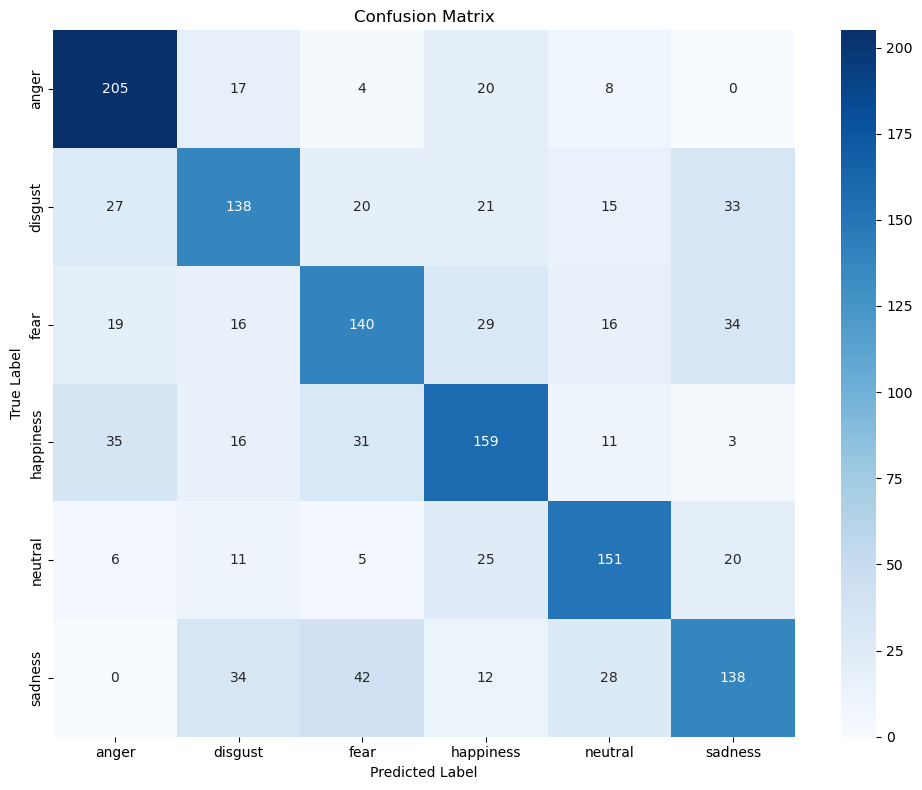

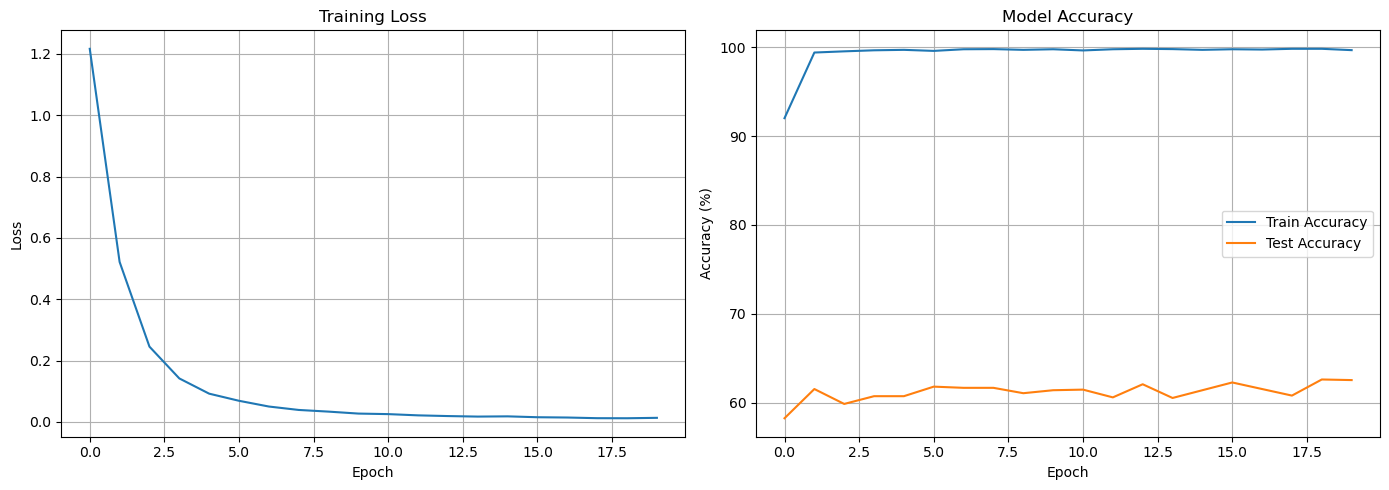

In [ ]:
graph_model(history, le_wav2vec)

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-6, weight_decay=1e-3, num_epochs=20)

Epoch [ 1/20] | Loss: 1.7329 | Train Acc: 33.46% | Test Acc: 40.63% *
Epoch [ 2/20] | Loss: 1.5895 | Train Acc: 79.54% | Test Acc: 47.75% *
Epoch [ 3/20] | Loss: 1.4625 | Train Acc: 87.67% | Test Acc: 58.76% *
Epoch [ 4/20] | Loss: 1.3404 | Train Acc: 98.66% | Test Acc: 59.97% *
Epoch [ 5/20] | Loss: 1.2265 | Train Acc: 99.50% | Test Acc: 60.44% *
Epoch [ 6/20] | Loss: 1.1194 | Train Acc: 99.55% | Test Acc: 60.58% *
Epoch [10/20] | Loss: 0.7787 | Train Acc: 99.56% | Test Acc: 59.91% 
Epoch [15/20] | Loss: 0.4957 | Train Acc: 99.76% | Test Acc: 59.30% 
Early stopping at epoch 16
Best test accuracy: 60.58% at epoch 6



Classification Report:
              precision    recall  f1-score   support

       anger       0.67      0.81      0.73       254
     disgust       0.60      0.41      0.49       254
        fear       0.58      0.52      0.55       254
   happiness       0.54      0.58      0.56       255
     neutral       0.60      0.68      0.64       218
     sadness       0.55      0.56      0.56       254

    accuracy                           0.59      1489
   macro avg       0.59      0.59      0.59      1489
weighted avg       0.59      0.59      0.59      1489



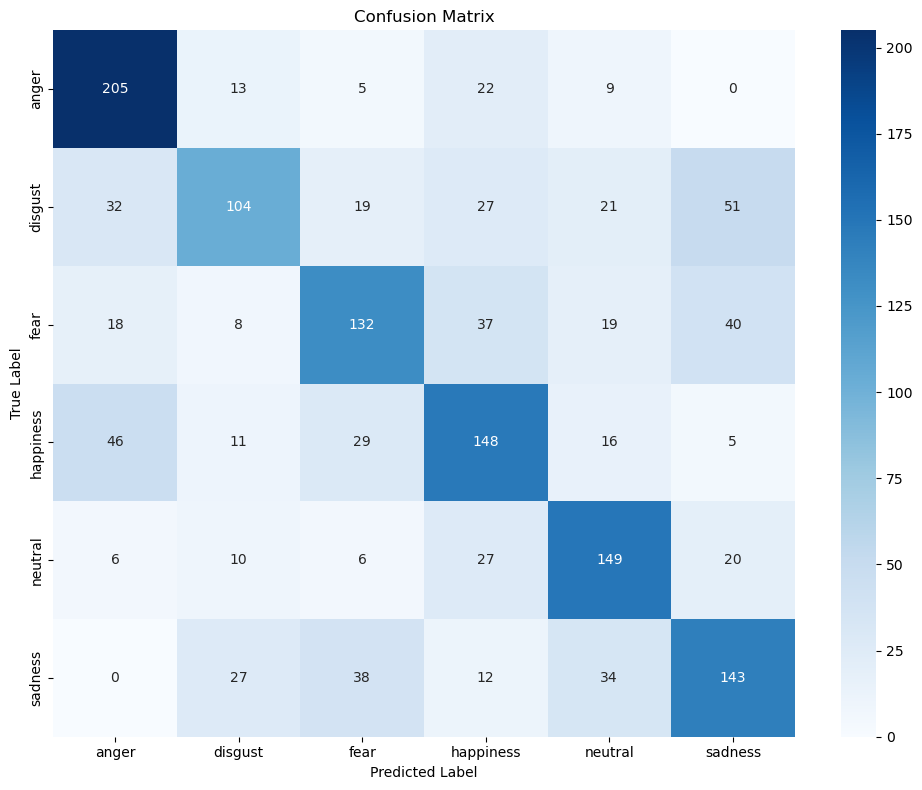

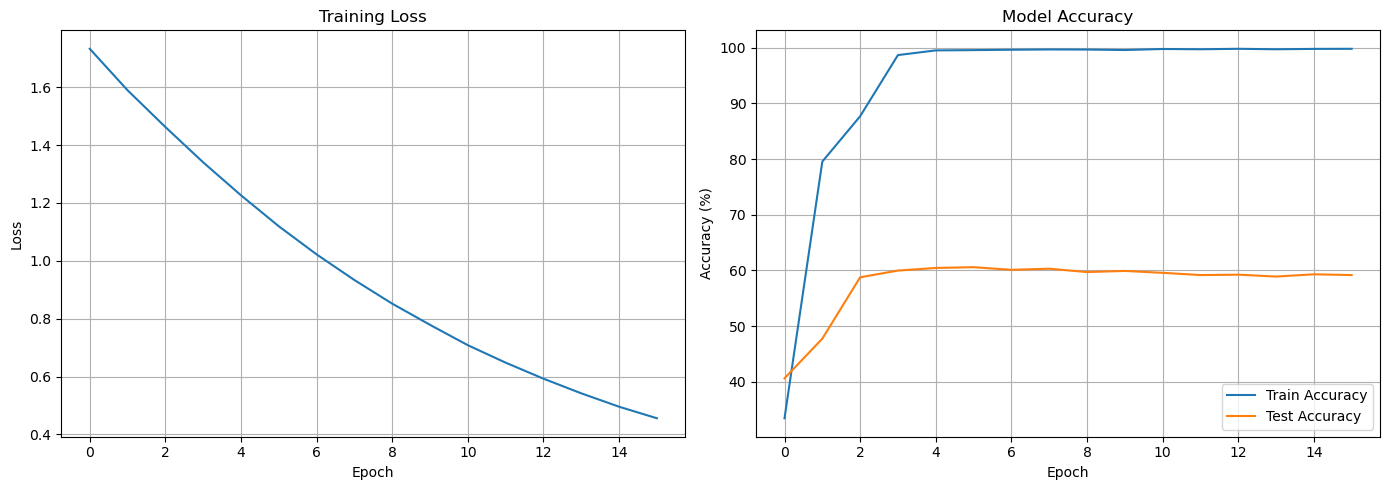

In [ ]:
graph_model(history, le_wav2vec)

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-6, weight_decay=1e-2, num_epochs=20)

Epoch [ 1/20] | Loss: 1.7272 | Train Acc: 22.44% | Test Acc: 31.97% *
Epoch [ 2/20] | Loss: 1.6080 | Train Acc: 48.58% | Test Acc: 40.97% *
Epoch [ 3/20] | Loss: 1.5153 | Train Acc: 72.28% | Test Acc: 47.75% *
Epoch [ 4/20] | Loss: 1.4222 | Train Acc: 83.44% | Test Acc: 50.91% *
Epoch [ 5/20] | Loss: 1.3275 | Train Acc: 91.18% | Test Acc: 52.99% *
Epoch [ 6/20] | Loss: 1.2384 | Train Acc: 93.33% | Test Acc: 54.94% *
Epoch [ 8/20] | Loss: 1.0701 | Train Acc: 96.04% | Test Acc: 55.47% *
Epoch [ 9/20] | Loss: 0.9914 | Train Acc: 96.86% | Test Acc: 55.81% *
Epoch [10/20] | Loss: 0.9192 | Train Acc: 96.99% | Test Acc: 55.81% 
Epoch [11/20] | Loss: 0.8535 | Train Acc: 97.50% | Test Acc: 56.35% *
Epoch [12/20] | Loss: 0.7907 | Train Acc: 97.56% | Test Acc: 56.55% *
Epoch [15/20] | Loss: 0.6330 | Train Acc: 98.25% | Test Acc: 56.28% 
Epoch [16/20] | Loss: 0.5918 | Train Acc: 98.03% | Test Acc: 56.62% *
Epoch [17/20] | Loss: 0.5489 | Train Acc: 98.15% | Test Acc: 57.49% *
Epoch [20/20] | Loss: 

In [ ]:
history = run_model(model, train_loader_wav2vec, test_loader_wav2vec, learning_rate=1e-6, weight_decay=1e-1, num_epochs=20)

Epoch [ 1/20] | Loss: 1.7072 | Train Acc: 32.34% | Test Acc: 32.98% *
Epoch [ 2/20] | Loss: 1.5918 | Train Acc: 67.51% | Test Acc: 48.62% *
Epoch [ 3/20] | Loss: 1.4894 | Train Acc: 84.76% | Test Acc: 54.94% *
Epoch [ 4/20] | Loss: 1.3982 | Train Acc: 91.25% | Test Acc: 58.16% *
Epoch [ 5/20] | Loss: 1.3163 | Train Acc: 96.52% | Test Acc: 59.84% *
Epoch [ 6/20] | Loss: 1.2405 | Train Acc: 99.08% | Test Acc: 60.51% *
Epoch [ 7/20] | Loss: 1.1728 | Train Acc: 99.28% | Test Acc: 60.78% *
Epoch [10/20] | Loss: 1.0086 | Train Acc: 98.99% | Test Acc: 60.31% 
Epoch [15/20] | Loss: 0.8332 | Train Acc: 98.61% | Test Acc: 59.37% 
Early stopping at epoch 17
Best test accuracy: 60.78% at epoch 7
